# Visualize spherical harmonic filters in the spatial domain
*Author: R. Rietbroek Feb 2024 (r.rietbroek@utwente.nl)*

Spherical harmonic coefficients can be filtered in the spectral domain with various filters. However, intuitively, it is difficult to understand the impact of the filter on the signal.

This notebook serves to illustrate how spatial visualizations fo the filter operations can be constructed. This can be realized by:
1. Constructing a unit load in the spherical harmonic domain centered at specified locations
2. Apply a filter of choice to the unit load
3. Apply a Spherical harmonic synthesis to the resulting coefficients (on a grid around the center of the load)
4. Plot the results in the spatial domain

The Gaussian filter is described in 
[Wahr, J., Molenaar, M., Bryan, F., 1998. Time variability of the Earth’s gravity field: Hydrological and oceanic effects and their possible detection using GRACE. Journal of Geophysical Research 103, 30205–30230]( https://doi.org/10.1029/98JB02844)
Information on the anisotropic DDK filters can be found:
* On the [github repository](https://github.com/strawpants/GRACE-filter/) containing the filter coefficients
* in [Kusche et al. 2009](https://link.springer.com/article/10.1007/s00190-009-0308-3)



## 1. Import the necessary modules

In [1]:
#Optionally enable autoreloading for development purposes. Note that this does not automagically reload the binary extensions
%load_ext autoreload
%autoreload 2
#also supress some warnings from pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
import shxarray
import xarray as xr
import numpy as np
import matplotlib.pyplot as mpl

## 2. Define a set of locations and create unit loads at the specified locations

In [3]:
lon=[20,-60]
lat=[65,-5]

#create an isotropic unitload kernel up to degree and order 120
nmax=120
unitkernel=shxarray.kernels.axial.Unit(nmax)

# position the unit loads on the specified locations on the sphere
daunit=unitkernel.position(lon=lon,lat=lat)

## 3. Filter the unit loads with a Gaussian filter


In [4]:
dsfiltered=daunit.sh.filter('Gauss300').to_dataset()
# or alternatively
# dsfiltered=daunit.sh.filter('Gauss',halfwidth=300).to_dataset()

## 4. Add a version which is filtered with an anisotropic DDK4 filter

In [6]:
# Note setting truncate to False below keeps coefficients below the minimum degree of the filter to their original values
ddk4=daunit.sh.filter('DDK4',truncate=False)
# assign to dataset variable but make sure they are sorted in the same order
dsfiltered['ddk4']=ddk4.sel(nm=dsfiltered.nm)


## 5. Apply spherical harmonic synthesis on grids centered on the locations

In [7]:
def getlonlatspan(clon,clat):
    """quick function to get a lon/lat grid around a central point"""
    dist=10 #half size of the blocks in degrees
    step=0.2
    long=np.arange(clon-dist,clon+dist,step)
    latg=np.arange(clat-dist,clat+dist,step)
    return long,latg
#dspos1=dsfiltered.sh.synthesis(lon=lon1g,lat=lat1g)

In [8]:
lon1g,lat1g=getlonlatspan(lon[0],lat[0])
dspos1=dsfiltered.sel(nlonlat=0).sh.synthesis(lon=lon1g,lat=lat1g)
#also normalize to the central value
dspos1=dspos1/dspos1.max()

lon2g,lat2g=getlonlatspan(lon[1],lat[1])
dspos2=dsfiltered.sel(nlonlat=1).sh.synthesis(lon=lon2g,lat=lat2g)
#also normalize to the central value
dspos2=dspos2/dspos2.max()



## 6. Visualize the filter kernels

Text(0.5, 1.0, 'DDK at lon,lat: (-60,-5)')

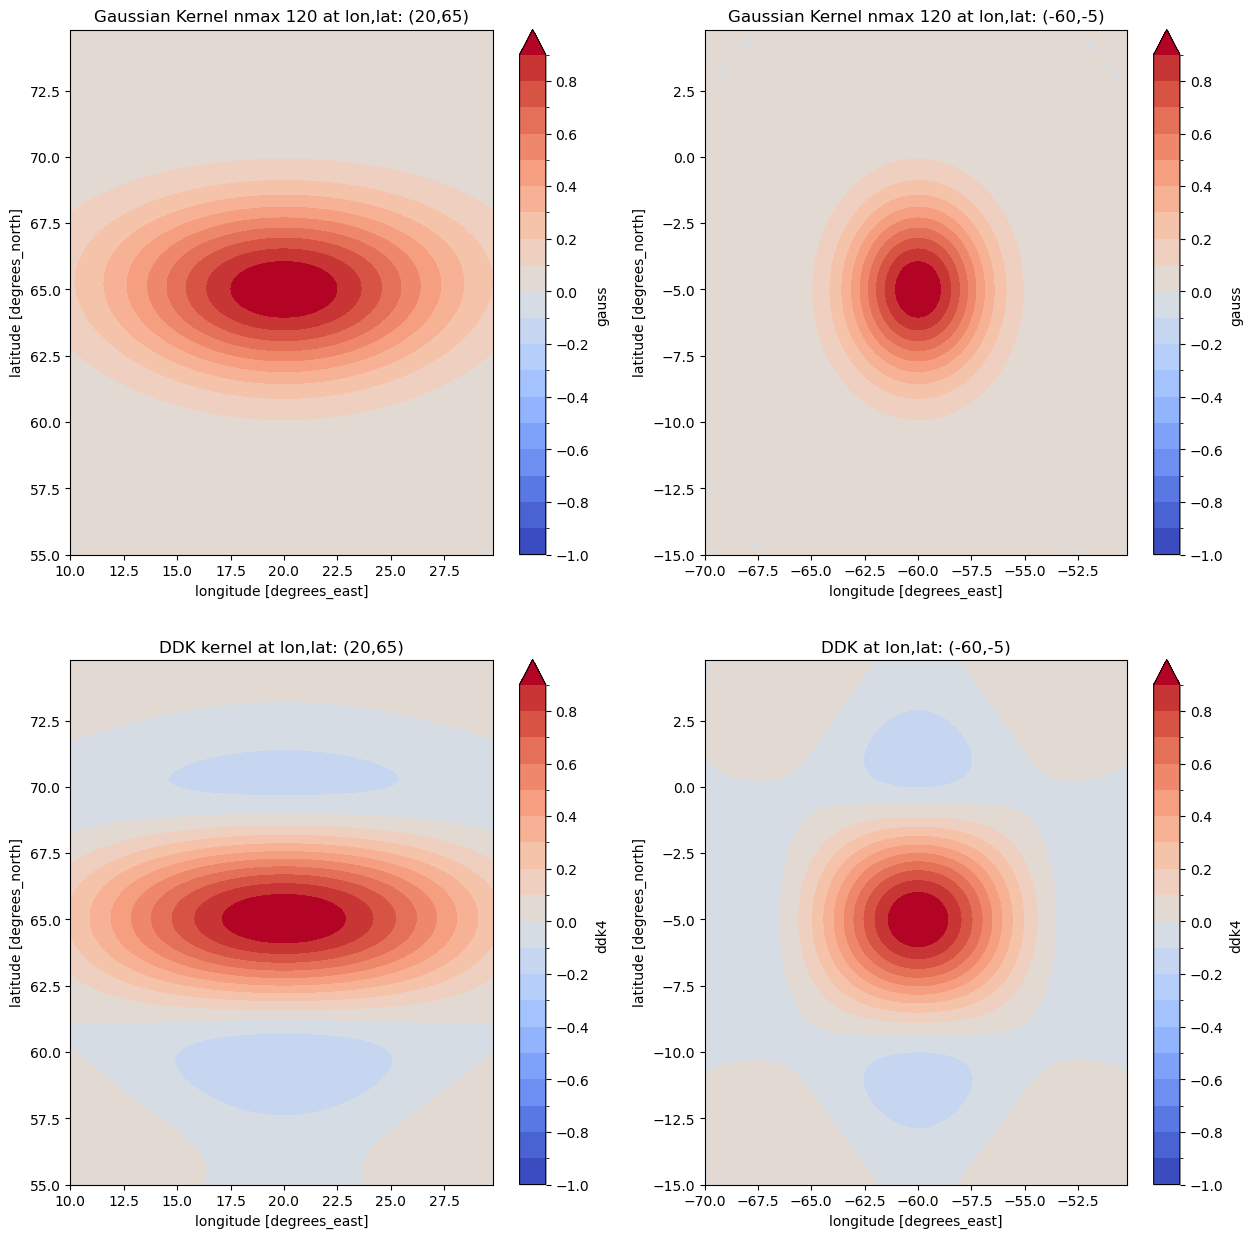

In [9]:
fig, axs = mpl.subplots(ncols=2,nrows=2,figsize=(15, 15))
vmin=-1
vmax=1

pargs={"cmap":'coolwarm','vmin':vmin,'vmax':vmax,"levels":np.arange(vmin,vmax,0.1)}
pgss1=dspos1.gauss.plot.contourf(ax=axs[0][0],**pargs)
pgss2=dspos2.gauss.plot.contourf(ax=axs[0][1],**pargs)
axs[0][0].set_title(f"Gaussian Kernel nmax {nmax} at lon,lat: ({lon[0]},{lat[0]})")
axs[0][1].set_title(f"Gaussian Kernel nmax {nmax} at lon,lat: ({lon[1]},{lat[1]})")

pddk1=dspos1.ddk4.plot.contourf(ax=axs[1][0],**pargs)
pddk2=dspos2.ddk4.plot.contourf(ax=axs[1][1],**pargs)
axs[1][0].set_title(f"DDK kernel at lon,lat: ({lon[0]},{lat[0]})")
axs[1][1].set_title(f"DDK at lon,lat: ({lon[1]},{lat[1]})")


## 7. Interpretation
From the plots above one can observe that although the spatial scales associated with the Gaussian kernel and the DDK4 filter are comparable in magnitude, the **anisotropic kernel has negative North-South lobes**. These partly mitigate the typical **North-South stripes** which are encountered in unfiltered GRACE and GRACE-FO data.